In [3]:
#### Load packages ####
library(dplyr)
library(CellChat)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: 'igraph'


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following object is masked from 'package:tibble':

    as_data_frame


The following object is masked from 'package:Seurat':

    components


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union


Loading required package: ggplot2



[1] "c:/Users/dekel/bioinformatics-code-hub/single-cell/ligand-receptor analysis"

Loading required package: SeuratObject

Loading required package: sp


Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t


New names:
• `` -> `...1`
Rows: 54750 Columns: 9995
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr    (1): ...1
dbl (9994): SC_92563_0_69, SC_92563_0_17, SC_92563_0_23, SC_92563_0_12, SC_9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 7495 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): ID, Condition, Group, Cluster_ID, CellType
dbl (2): nGene, nUMI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"Feature names cannot have underscores ('_'), replacing

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9312
Number of edges: 323604

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8992
Number of communities: 15
Elapsed time: 0 seconds


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
21:59:50 UMAP embedding parameters a = 0.9922 b = 1.112

21:59:50 Read 9312 rows and found 10 numeric columns

21:59:50 Using Annoy for neighbor search, n_neighbors = 30

21:59:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:59:50 Writing NN index file to temp file C:\Users\dekel\AppData\Local\Temp\RtmpOm4D1T\file6ff83c28528f

21:59:50 Searching Annoy index using 1 thread, search_k = 3000

21:59:53 Annoy recall = 100%

21:59:53 Commencing smooth kNN distance calibration using 1 thre

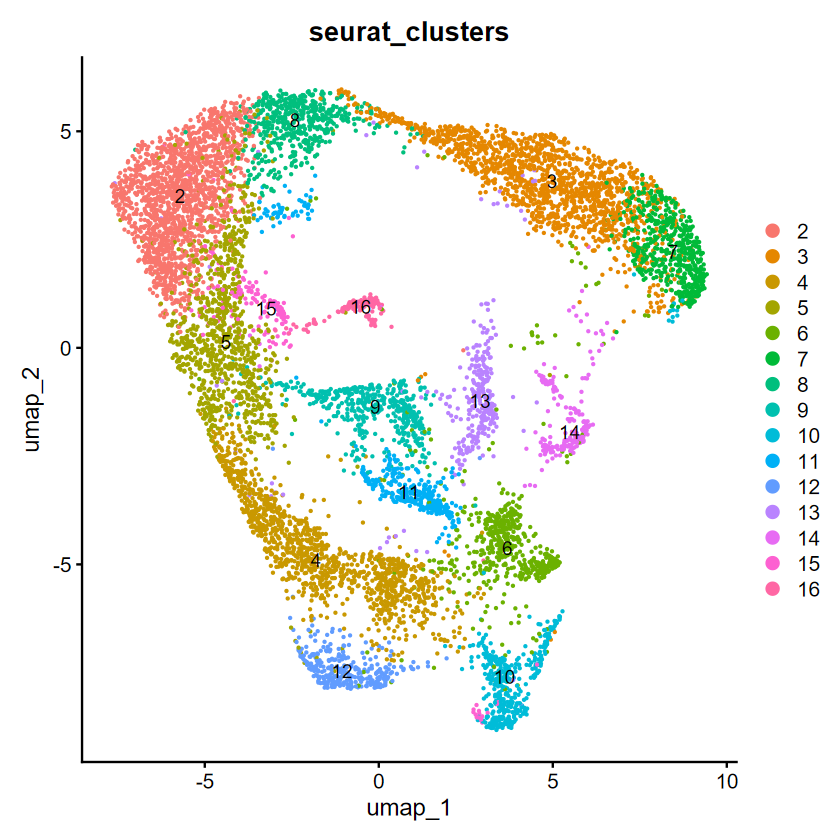

In [1]:
#### Load data ####
source(file.path(
  "..",
  "preprocessing",
  "load_and_prepare_seurat.R"
))

expression_matrix <- file.path(
  "..",
  "data",
  "GSE109816_normal_heart_umi_matrix.csv.gz"
)
metadata_path <- file.path(
  "..",
  "data",
  "GSE109816_normal_heart_cell_cluster_info.txt"
)

seu_obj <- adult_heart(
  expression_matrix = expression_matrix,
  metadata_path = metadata_path
)

## Increment cluster labels by 1 because cellchat hates 0's
# Ideally you should
seu_obj$seurat_clusters <- as.factor(as.numeric(seu_obj$seurat_clusters) + 1)
DimPlot(seu_obj, reduction = "umap", label = TRUE, group.by = "seurat_clusters")

In [4]:
#### Create a CellChat object ####
cellchat <- createCellChat(object = seu_obj, group.by = "seurat_clusters")

# Set the default database (Secreted Signaling or ECM-Receptor datasets)
# there is also mouse and zebrafish databases available
# Assign the database to the CellChat object
cellchat@DB <- CellChatDB.human # If working with human data


[1] "Create a CellChat object from a Seurat object"
The `data` slot in the default assay is used. The default assay is RNA 
The `meta.data` slot in the Seurat object is used as cell meta information 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 


In [5]:
#### Identify Overexpressed Genes and Ligand-Receptor Pairs ####
# Subset expression data to overexpressed genes
cellchat <- subsetData(cellchat) # Filter out genes based on their expression
# Identify overexpressed ligands/receptors
cellchat <- identifyOverExpressedGenes(cellchat)
# Identify overexpressed interactions between cell types
cellchat <- identifyOverExpressedInteractions(cellchat)

In [6]:
#### Calculate Communication Probabilities ####
# Calculate communication probabilities
cellchat <- computeCommunProb(cellchat)

# Filter out communications with low probabilities
cellchat <- filterCommunication(cellchat, min.cells = 10)

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-10-06 22:01:52.543415]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-10-06 22:04:30.985408]"


In [7]:
#### Infer the communication network at the pathway level ####
# Infer the communication network at the pathway level
cellchat <- computeCommunProbPathway(cellchat)
# Aggregate the inferred cell-cell communications
cellchat <- aggregateNet(cellchat)

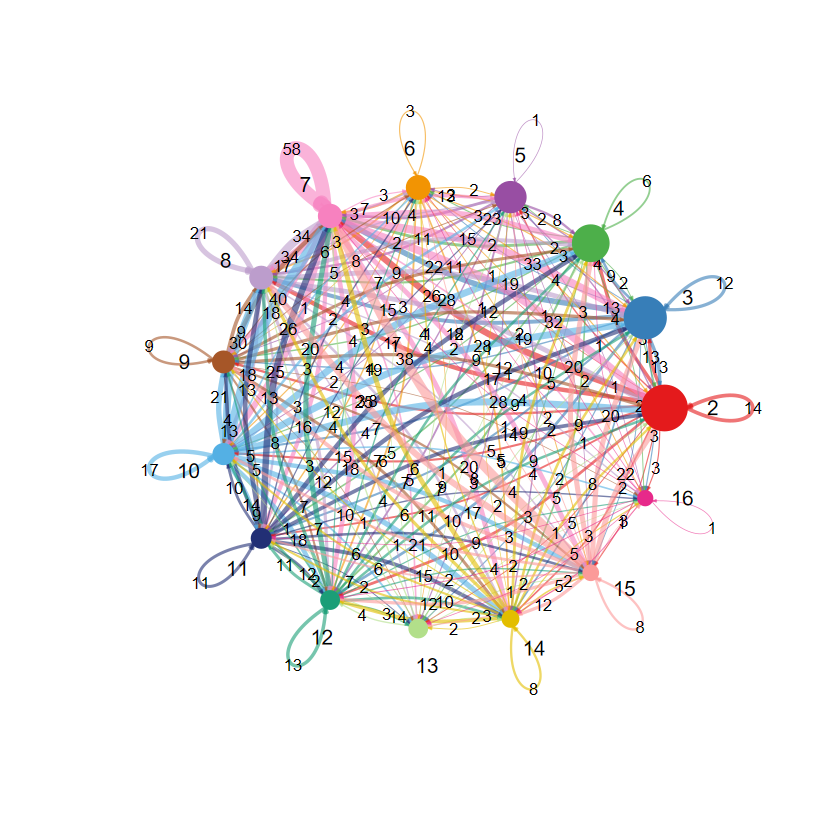

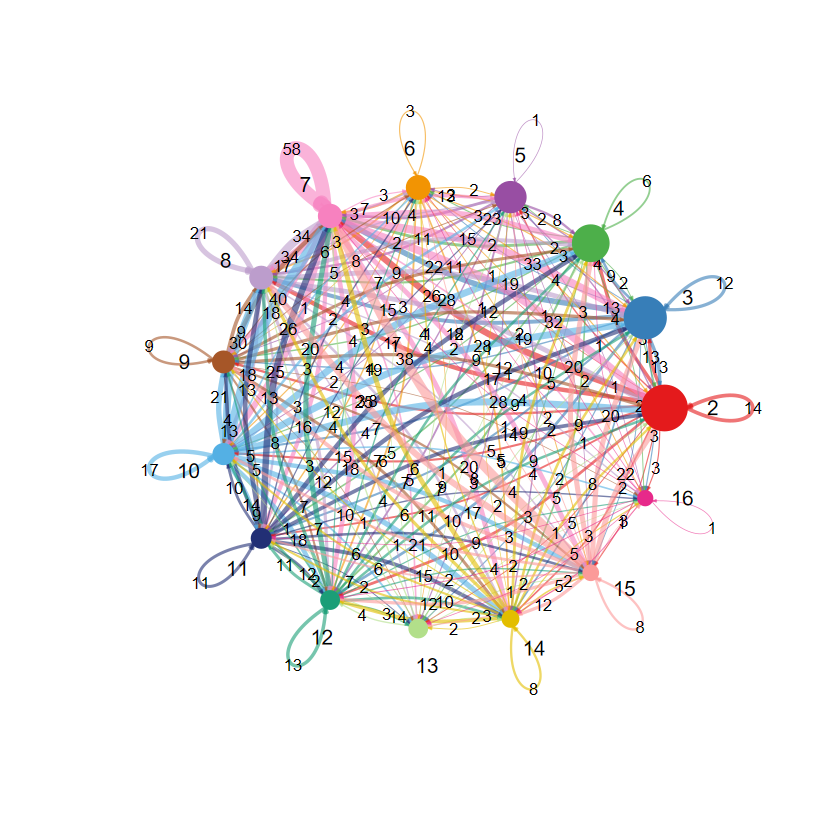

In [8]:
#### Visualize the communication network ####
# Plot the aggregated network
netVisual_circle(
  cellchat@net$count,
  vertex.weight = as.numeric(table(cellchat@idents)),
  weight.scale = TRUE,
  label.edge = TRUE
)

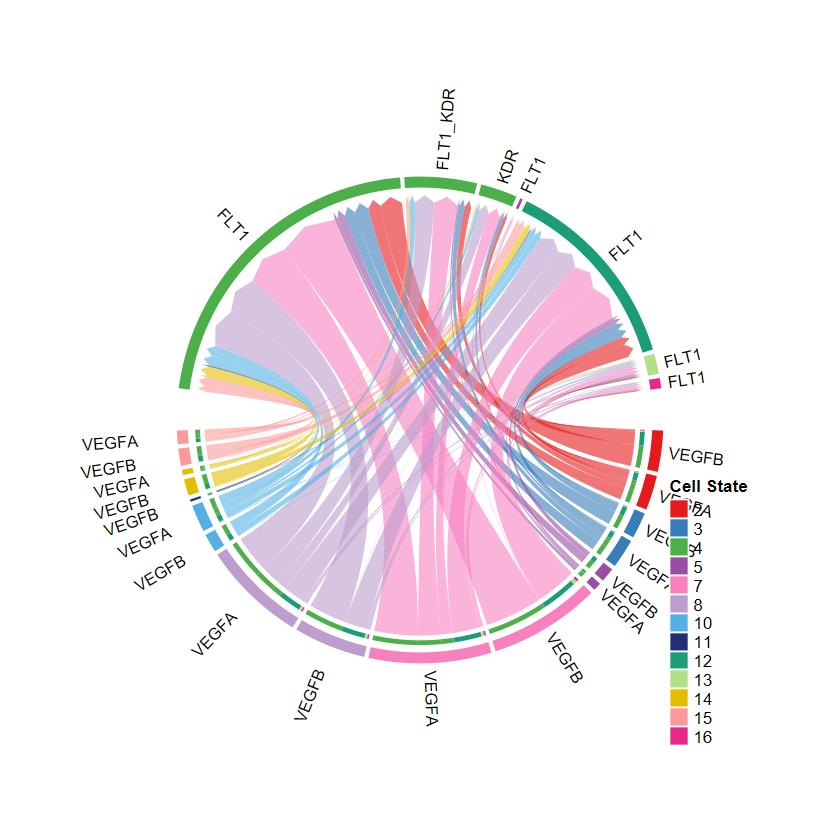

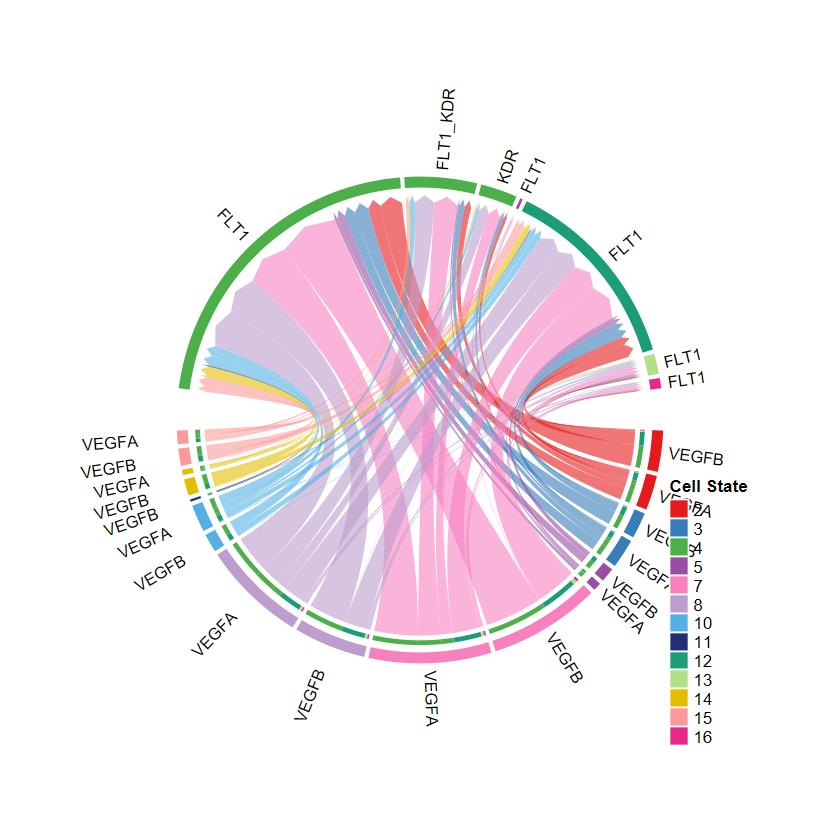

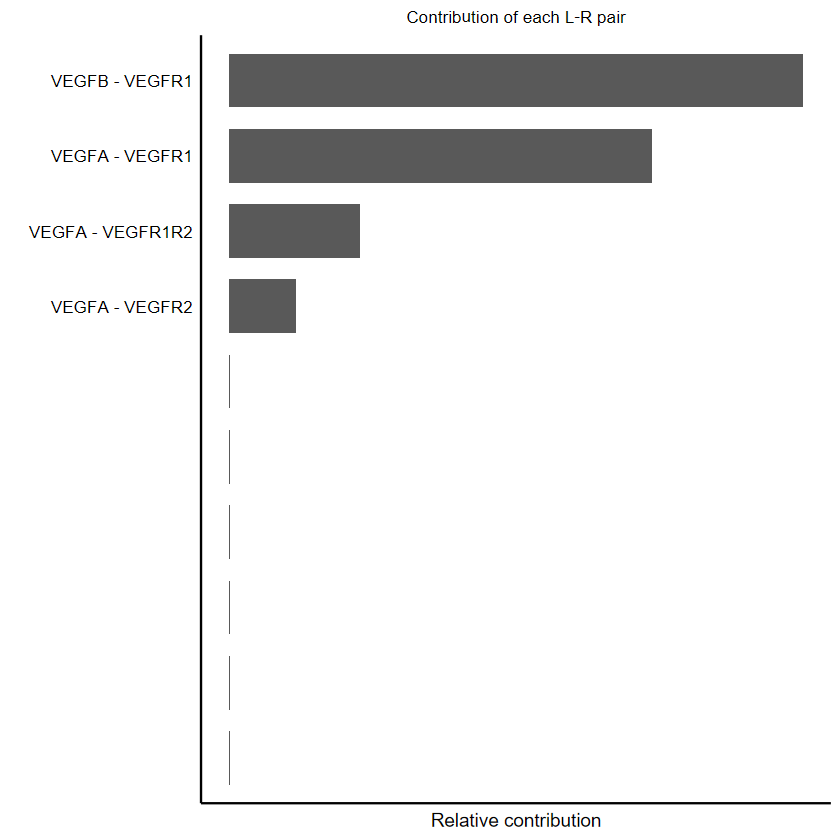

In [9]:
# Chord diagram for a specific signaling pathway, e.g., "WNT"
netVisual_chord_gene(cellchat, signaling = "VEGF")
# Visualize contribution of ligands/receptors in a specific signaling pathway
netAnalysis_contribution(cellchat, signaling = "VEGF")


Do heatmap based on a single object 




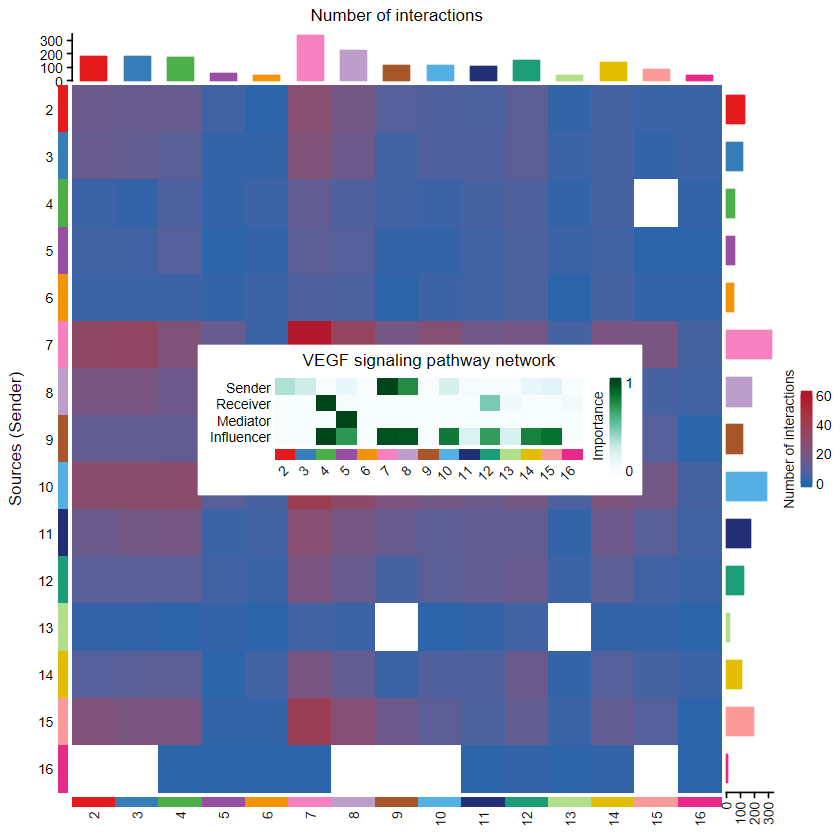

In [10]:
# Heatmap for all signaling pathways
netVisual_heatmap(cellchat)
# Hierarchical plot for a specific signaling pathway, e.g., "WNT"
cellchat <- netAnalysis_computeCentrality(
  cellchat,
  slot.name = "netP"
)
netAnalysis_signalingRole_network(
  cellchat,
  signaling = "VEGF",
  slot.name = "netP"
)

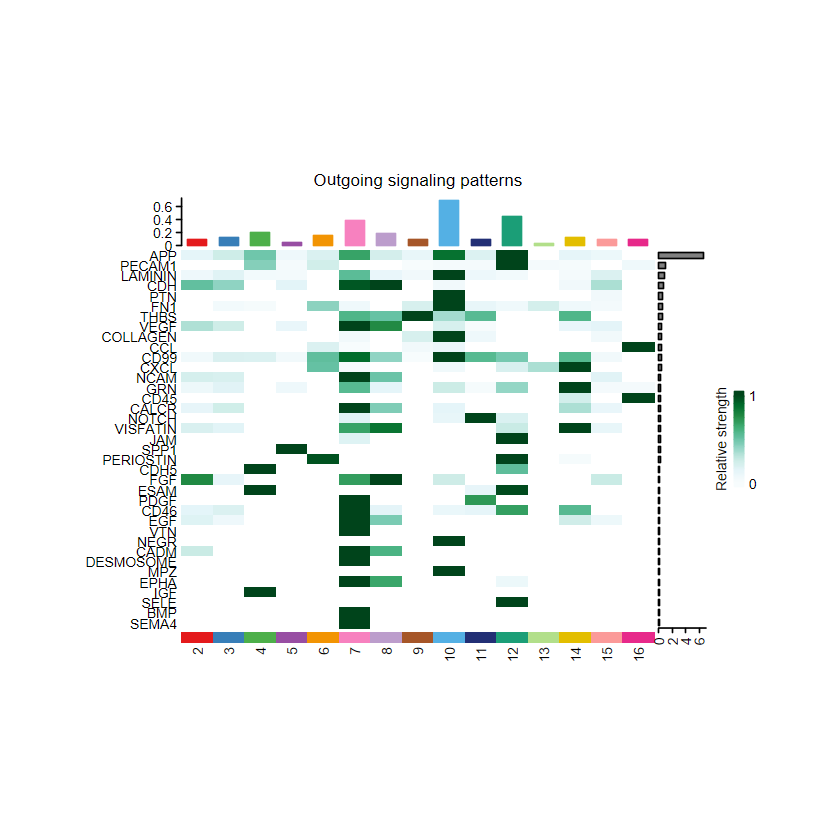

In [11]:
# Heatmap showing the role of different cell types as senders or receivers
# View both outgoing and incoming roles for VEGF pathway
netAnalysis_signalingRole_heatmap(
  cellchat,
  pattern = "outgoing"
) # For outgoing (sending)

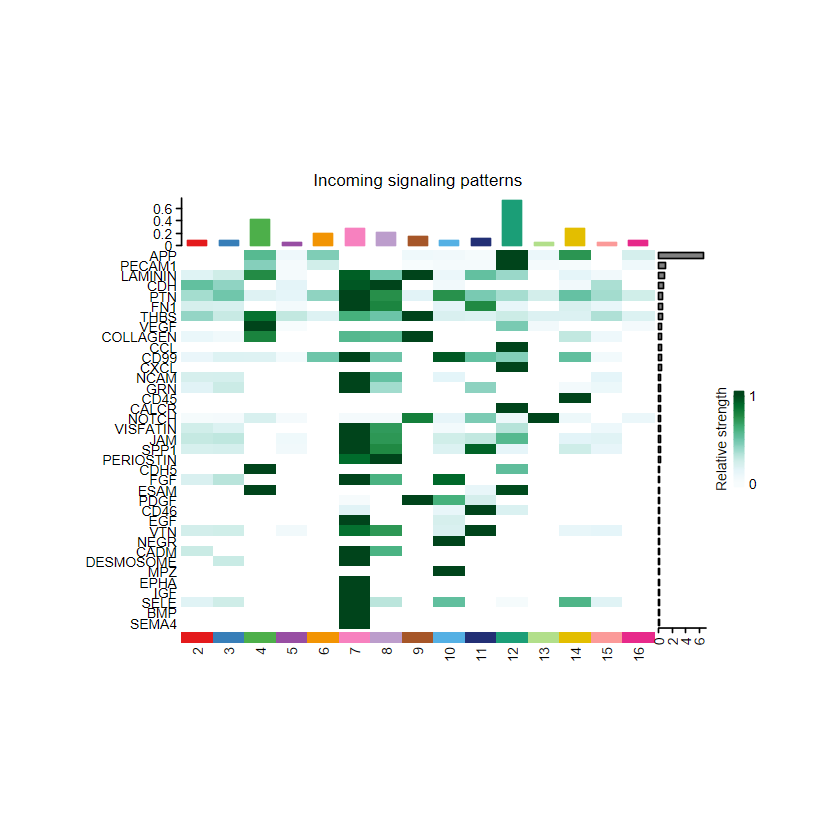

In [12]:
netAnalysis_signalingRole_heatmap(
  cellchat,
  pattern = "incoming"
) # For incoming (receiving)
